<a href="https://colab.research.google.com/github/alimanfoo/sandbox/blob/master/2021-04-28-ag3-cnv-guide/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ag1000G phase 3 CNV guide

**2021-05-12**

This notebook provides information on how to access copy number variant (CNV) data from Ag1000G phase 3. 

N.B., these data are not publicly released yet, and this guide is intended only for members of the Ag1000G Consortium at this time.

If you have any questions, please start a new topic in the [Ag1000G discourse site](https://discourse.malariagen.net/c/ag1000g/5) or drop me an email (alistair.miles@sanger.ac.uk).

## CNV data types

There are three different types of CNV data available:

* **Hidden Markov model (HMM)** - results of running an HMM to predict copy number state in 300 bp windows across the genome from coverage data for each individual sample.
* **Coverage calls** - genome-wide CNV calls generated by inferring CNVs from the HMM results and then clustering CNV alleles based on breakpoint proximity. Note that the calling was performed separately for *An. arabiensis* samples and for samples that are not *An. arabiensis*. 
* **Discordant read calls** - CNV genotypes at selected loci generated from analysis of discordant reads at CNV breakpoints.

These data were generated by Eric Lucas at LSTM and methods used follow those given in [Lucas et al. (2019)](https://genome.cshlp.org/content/29/8/1250).

## Data hosting

All CNV data are available from the `vo_agam_release` bucket in Google Cloud Storage at the path `gs://vo_agam_release/v3/cnv`.

HMM CNV data are available in either VCF, Zarr or text formats. CNV coverage calls and discordant read calls are available in either VCF or Zarr formats.

Data can either be downloaded to a local file system or accessed directly via cloud computing services such as Google Colab.

## Cloud access

Data can be accessed directly in the cloud, e.g., via Google Colab. 

The `malariagen_data` Python package provides some convenience functions for accessing these data. 

In [1]:
# recommended package installs for Google Colab - takes a couple of minutes to compile scikit-allel
!pip install -q \
    zarr==2.6.1 \
    fsspec==0.8.7 \
    gcsfs==0.7.2 \
    dask==2021.03.0 \
    xarray==0.18.0 \
    scikit-allel==1.3.3 \
    bokeh==2.3.2


In [ ]:
# new CNV functionality currently only available in prerelease
!pip install --pre --upgrade malariagen_data

In [4]:
# set up cloud data access
import malariagen_data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

### HMM

Access HMM data via the `cnv_hmm()` method, which returns an xarray dataset. E.g.:

In [5]:
ds_hmm = ag3.cnv_hmm(contig="2R", sample_sets="AG1000G-TZ")
ds_hmm

<xarray.Dataset>
Dimensions:           (samples: 300, variants: 205151)
Coordinates:
    variant_position  (variants) int32 dask.array<chunksize=(205151,), meta=np.ndarray>
    variant_end       (variants) int32 dask.array<chunksize=(205151,), meta=np.ndarray>
    variant_contig    (variants) uint8 dask.array<chunksize=(205151,), meta=np.ndarray>
    sample_id         (samples) object dask.array<chunksize=(300,), meta=np.ndarray>
Dimensions without coordinates: samples, variants
Data variables:
    call_CN           (variants, samples) int8 dask.array<chunksize=(205151, 300), meta=np.ndarray>
    call_RawCov       (variants, samples) int32 dask.array<chunksize=(131072, 128), meta=np.ndarray>
    call_NormCov      (variants, samples) float32 dask.array<chunksize=(131072, 128), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

Here "variants" are the 300 bp windows in which coverage was calculated and the HMM fitted. Window start positions are given by the `variant_position` array and ends are given by `variant_end`.

In [6]:
pos = ds_hmm['variant_position'].values
pos

array([       1,      301,      601, ..., 61544401, 61544701, 61545001],
      dtype=int32)

In [7]:
end = ds_hmm['variant_end'].values
end

array([     300,      600,      900, ..., 61544700, 61545000, 61545105],
      dtype=int32)

Copy number state is given by the `call_CN` array, where rows are windows and columns are individual samples. 

On the autosomes (2R, 2L, 3R, 3L) normal diploid copy number is 2. Values greater than 2 mean amplification, less then 2 mean deletion. 

On the X chromosome, normal copy number is 2 in females and 1 in males. 

For all chromosomes, -1 means missing, i.e., the window was not included. 

Rows are variants (windows), columns are individual samples.

In [8]:
cn = ds_hmm['call_CN'].values
cn

array([[ 5,  2,  2, ...,  6,  4,  2],
       [ 5,  2,  2, ...,  6,  4,  2],
       [ 5, 11,  8, ...,  6,  4,  2],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)

Convenience function to compute modal coverage by gene:

In [9]:
ds_gene_cnv = ag3.gene_cnv(contig="2R", sample_sets="AG1000G-TZ")
ds_gene_cnv

<xarray.Dataset>
Dimensions:        (genes: 3668, samples: 300)
Coordinates:
    gene_id        (genes) object 'AGAP001096' 'AGAP013094' ... 'AGAP004676'
    gene_start     (genes) int64 3426 13754 18496 ... 61303692 61372543 61478226
    gene_end       (genes) int64 9985 15149 19579 ... 61306248 61418536 61478802
    sample_id      (samples) object 'BL0046-C' 'BL0047-C' ... 'BL0250-CW'
Dimensions without coordinates: genes, samples
Data variables:
    gene_windows   (genes) int64 23 6 5 8 33 63 19 29 ... 168 546 57 80 10 154 3
    gene_name      (genes) object nan nan nan nan nan ... nan nan 'GPRMAC2' nan
    gene_strand    (genes) object '+' '+' '+' '+' '-' ... '+' '+' '-' '+' '+'
    CN_mode        (genes, samples) int8 2 2 2 2 2 2 2 2 2 ... 3 3 3 4 4 3 4 2 1
    CN_mode_count  (genes, samples) int64 23 23 23 23 23 23 23 ... 2 2 3 3 3 3 1

Convenience function to compute CNV frequencies by gene and population:

In [10]:
pops = {
    'tz_gamb': "sample_set == 'AG1000G-TZ' and species == 'gambiae'",
    'tz_arab': "sample_set == 'AG1000G-TZ' and species == 'arabiensis'",
}
df_gene_cnv_freqs = ag3.gene_cnv_frequencies(contig='2R', populations=pops)
df_gene_cnv_freqs

,seqid,start,end,strand,Name,tz_gamb_amp,tz_gamb_del,tz_arab_amp,tz_arab_del
ID,,,,,,,,,
AGAP001096,2R,3426,9985,+,NaN,0.014706,0.058824,0.000000,0.004444
AGAP013094,2R,13754,15149,+,NaN,0.000000,0.044118,0.004444,0.004444
AGAP001097,2R,18496,19579,+,NaN,0.000000,0.044118,0.000000,0.004444
AGAP001098,2R,19797,21866,+,NaN,0.000000,0.044118,0.000000,0.004444
AGAP001099,2R,21882,31394,-,NaN,0.000000,0.044118,0.004444,0.004444
...,...,...,...,...,...,...,...,...,...
AGAP004671,2R,61176240,61192895,+,NaN,0.014706,0.029412,0.004444,0.000000
AGAP004672,2R,61230781,61254533,+,NaN,0.000000,0.044118,0.008889,0.004444
AGAP004674,2R,61303692,61306248,-,NaN,0.000000,0.073529,0.000000,0.080000


### Coverage calls

Access the coverage calls via the `cnv_coverage_calls()` method, which returns an xarray dataset. Note that an `analysis` parameter must be given, which can be either "arab" for *An. arabiensis* samples or "gamb_colu" for non-*An. arabiensis*. E.g.:

In [11]:
ds_cov = ag3.cnv_coverage_calls(contig='2R', analysis='arab', sample_set='AG1000G-TZ')
ds_cov

<xarray.Dataset>
Dimensions:              (samples: 221, variants: 9459)
Coordinates:
    variant_position     (variants) int32 dask.array<chunksize=(9459,), meta=np.ndarray>
    variant_end          (variants) int32 dask.array<chunksize=(9459,), meta=np.ndarray>
    variant_contig       (variants) uint8 dask.array<chunksize=(9459,), meta=np.ndarray>
    variant_id           (variants) object dask.array<chunksize=(9459,), meta=np.ndarray>
    sample_id            (samples) object dask.array<chunksize=(221,), meta=np.ndarray>
Dimensions without coordinates: samples, variants
Data variables:
    variant_CIPOS        (variants) int32 dask.array<chunksize=(9459,), meta=np.ndarray>
    variant_CIEND        (variants) int32 dask.array<chunksize=(9459,), meta=np.ndarray>
    variant_filter_pass  (variants) bool dask.array<chunksize=(9459,), meta=np.ndarray>
    call_genotype        (variants, samples) int8 dask.array<chunksize=(9459, 221), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

Here "variants" are copy number variants, inferred from the HMM results. CNV start positions are given by the `variant_position` array and ends are given by `variant_end`.

In [12]:
pos = ds_cov['variant_position'].values
pos

array([       1,        1,      601, ..., 61514401, 61515901, 61533301],
      dtype=int32)

In [13]:
end = ds_cov['variant_end'].values
end

array([    1500,     2100,     2100, ..., 61517400, 61517700, 61535700],
      dtype=int32)

CNV genotypes are given by the `call_genotype` array, coded as 0 for absence and 1 for presence of the CNV allele. Rows are CNV alleles and columns are individual samples.

In [14]:
gt = ds_cov['call_genotype'].values
gt

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

### Discordant read calls

Access the discordant read calls via the `cnv_discordant_read_calls()` method. E.g.:

In [15]:
ds_dr = ag3.cnv_discordant_read_calls(contig="2R", sample_sets="AG1000G-TZ")
ds_dr

<xarray.Dataset>
Dimensions:                        (samples: 300, variants: 40)
Coordinates:
    variant_position               (variants) int32 dask.array<chunksize=(40,), meta=np.ndarray>
    variant_end                    (variants) int32 dask.array<chunksize=(40,), meta=np.ndarray>
    variant_id                     (variants) object dask.array<chunksize=(40,), meta=np.ndarray>
    variant_contig                 (variants) uint8 dask.array<chunksize=(40,), meta=np.ndarray>
    sample_id                      (samples) object dask.array<chunksize=(300,), meta=np.ndarray>
Dimensions without coordinates: samples, variants
Data variables:
    variant_Region                 (variants) object dask.array<chunksize=(40,), meta=np.ndarray>
    variant_StartBreakpointMethod  (variants) int32 dask.array<chunksize=(40,), meta=np.ndarray>
    variant_EndBreakpointMethod    (variants) int32 dask.array<chunksize=(40,), meta=np.ndarray>
    call_genotype                  (variants, samples) int8 dask.array<chunksize=(40, 300), meta=np.ndarray>
    sample_coverage_variance       (samples) float32 dask.array<chunksize=(300,), meta=np.ndarray>
    sample_is_high_variance        (samples) bool dask.array<chunksize=(300,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

CNV start positions are given by the `variant_position` array and ends are given by `variant_end`. Note that some starts and/or ends are not known, and missing values are coded as -1.

The identifier of the CNV alleles is given by the `variant_id` array. The region where CNV alleles were analysed is given by the `variant_Region` array.

CNV genotypes are given by the `call_genotype` array, coded as 0 for absence and 1 for presence of the CNV allele. Rows are CNV alleles and columns are individual samples.

In [16]:
vid = ds_dr['variant_id'].values
vid

array(['Ace1_Dup0', 'Cyp6aap_Dup0', 'Cyp6aap_Dup1', 'Cyp6aap_Dup23',
       'Ace1_Dup1', 'Ace1_Dup2', 'Ace1_Del1', 'Ace1_Del4', 'Ace1_Del3',
       'Ace1_Del2', 'Cyp6aap_Dup15', 'Cyp6aap_Dup13', 'Cyp6aap_Dup20',
       'Cyp6aap_Dup14', 'Cyp6aap_Dup12', 'Cyp6aap_Dup21', 'Cyp6aap_Dup19',
       'Cyp6aap_Dup8', 'Cyp6aap_Dup22', 'Cyp6aap_Dup17', 'Cyp6aap_Dup28',
       'Cyp6aap_Dup10', 'Cyp6aap_Dup7', 'Cyp6aap_Dup6', 'Cyp6aap_Dup4',
       'Cyp6aap_Dup30', 'Cyp6aap_Dup9', 'Cyp6aap_Dup3', 'Cyp6aap_Dup18',
       'Cyp6aap_Dup26', 'Cyp6aap_Dup1a', 'Cyp6aap_Dup1b', 'Cyp6aap_Dup25',
       'Cyp6aap_Dup5', 'Cyp6aap_Dup16', 'Cyp6aap_Dup24', 'Cyp6aap_Dup11',
       'Cyp6aap_Dup2', 'Cyp6aap_Dup29', 'Cyp6aap_Dup27'], dtype=object)

In [17]:
reg = ds_dr['variant_Region'].values
reg

array(['Ace1', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Ace1',
       'Ace1', 'Ace1', 'Ace1', 'Ace1', 'Ace1', 'Cyp6aa/Cyp6p',
       'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p',
       'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p',
       'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p',
       'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p',
       'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p',
       'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p',
       'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p', 'Cyp6aa/Cyp6p',
       'Cyp6aa/Cyp6p'], dtype=object)

In [18]:
pos = ds_dr['variant_position'].values
pos

array([      -1,       -1,       -1,       -1,  3436926,  3447950,
        3501850,  3512200,  3535850,  3539300, 28465673, 28472728,
       28473600, 28473874, 28474576, 28475128, 28475490, 28475996,
       28477220, 28477540, 28477710, 28477889, 28478057, 28478272,
       28478925, 28478987, 28479181, 28479407, 28479548, 28480166,
       28480189, 28480193, 28480335, 28480372, 28480547, 28480585,
       28487546, 28493547, 28494017, 28496700], dtype=int32)

In [19]:
end = ds_dr['variant_end'].values
end

array([      -1,       -1,       -1, 28497740,  3639836,  3518900,
        3599050,  3616290,  3619000,  3573750, 28555300, 28522671,
       28795255, 28563596, 28520016, 28483473, 28556726, 28485005,
       28484338, 28485380, 28496953, 28491215, 28486036, 28484157,
       28483069, 28485033, 28491431, 28483372, 28494597, 28483253,
       28483475, 28483675, 28483384, 28484518, 28483236, 28483442,
       28518123, 28497279, 28496505, 28499200], dtype=int32)

In [20]:
gt = ds_dr['call_genotype'].values
gt

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

## Data downloads

Data are organised in Google Cloud by sample set, and then CNV data type, under paths like `gs://vo_agam_release/v3/cnv/{sample_set}/{cnv_data_type}`. 

* E.g., the HMM data for sample set AG1000G-AO is at path `gs://vo_agam_release/v3/cnv/AG1000G-AO/hmm`
* E.g., the coverage calls for sample set AG1000G-TZ are at path `vo_agam_release/v3/cnv/AG1000G-TZ/coverage_calls`
* E.g., the discordant read calls for sample set AG1000G-MW are at path `gs://vo_agam_release/v3/cnv/AG1000G-MW/discordant_read_calls`

Data can be downloaded from Google Cloud to the local filesystem using `gsutil` program. Below are some examples of how to download selected portions of the data.

In [ ]:
# create a local directory to hold data
!mkdir -pv ~/vo_agam_release/v3/cnv/

In [ ]:
# download the HMM data in VCF format for all sample sets
!gsutil -m rsync -r \
    -x '.*/coverage_calls/.*|.*/discordant_read_calls/.*|.*/hmm/zarr/.*|.*/hmm/per_sample/.*' \
    gs://vo_agam_release/v3/cnv/ ~/vo_agam_release/v3/cnv/

In [ ]:
# download HMM data in Zarr format for all sample sets
!gsutil -m rsync -r \
    -x '.*/coverage_calls/.*|.*/discordant_read_calls/.*|.*/hmm/vcf/.*|.*/hmm/per_sample/.*' \
    gs://vo_agam_release/v3/cnv/ ~/vo_agam_release/v3/cnv/

In [ ]:
# download coverage calls in VCF format for all sample sets
!gsutil -m rsync -r \
    -x '.*/hmm/.*|.*/discordant_read_calls/.*|.*/coverage_calls/.*/zarr/.*' \
    gs://vo_agam_release/v3/cnv/ ~/vo_agam_release/v3/cnv/

In [ ]:
# download coverage calls in Zarr format for all sample sets
!gsutil -m rsync -r \
    -x '.*/hmm/.*|.*/discordant_read_calls/.*|.*/coverage_calls/.*/vcf/.*' \
    gs://vo_agam_release/v3/cnv/ ~/vo_agam_release/v3/cnv/


In [ ]:
# download discordant read calls for all sample sets
!gsutil -m rsync -r \
    -x '.*/hmm/.*|.*/coverage_calls/.*' \
    gs://vo_agam_release/v3/cnv/ ~/vo_agam_release/v3/cnv/

In [ ]:
# download all CNV data in VCF and Zarr formats for sample set AG1000G-TZ
!mkdir -pv ~/vo_agam_release/v3/cnv/AG1000G-TZ/
!gsutil -m rsync -r \
    -x 'hmm/per_sample/.*' \
    gs://vo_agam_release/v3/cnv/AG1000G-TZ/ ~/vo_agam_release/v3/cnv/AG1000G-TZ/

Below are commands illustrating the organisation of the downloaded files on the local file system:

In [ ]:
# setup for colab
!sudo apt install tree

In [ ]:
# inspect the files
!tree -L 1 ~/vo_agam_release/v3/cnv/AG1000G-TZ

/root/vo_agam_release/v3/cnv/AG1000G-TZ
├── coverage_calls
├── discordant_read_calls
└── hmm

3 directories, 0 files


In [ ]:
# inspect the HMM files
!tree -L 2 -a ~/vo_agam_release/v3/cnv/AG1000G-TZ/hmm

/root/vo_agam_release/v3/cnv/AG1000G-TZ/hmm
├── per_sample
│   ├── 2L
│   ├── 2R
│   ├── 3L
│   ├── 3R
│   └── X
├── vcf
│   ├── AG1000G-TZ_cnv_hmm.vcf.gz
│   ├── AG1000G-TZ_cnv_hmm.vcf.gz.tbi
│   └── .complete
└── zarr
    ├── 2L
    ├── 2R
    ├── 3L
    ├── 3R
    ├── samples
    ├── X
    ├── .zgroup
    └── .zmetadata

14 directories, 5 files


In [ ]:
# inspect the coverage calls files
!tree -L 3 -a ~/vo_agam_release/v3/cnv/AG1000G-TZ/coverage_calls

/root/vo_agam_release/v3/cnv/AG1000G-TZ/coverage_calls
├── arab
│   ├── .complete
│   ├── excluded_high_variance_samples.txt
│   ├── samples.txt
│   ├── vcf
│   │   ├── AG1000G-TZ_arab_cnv_coverage_calls.vcf.gz
│   │   └── AG1000G-TZ_arab_cnv_coverage_calls.vcf.gz.tbi
│   └── zarr
│       ├── 2L
│       ├── 2R
│       ├── 3L
│       ├── 3R
│       ├── samples
│       ├── X
│       ├── .zgroup
│       └── .zmetadata
└── gamb_colu
    ├── .complete
    ├── excluded_high_variance_samples.txt
    ├── samples.txt
    ├── vcf
    │   ├── AG1000G-TZ_gamb_colu_cnv_coverage_calls.vcf.gz
    │   └── AG1000G-TZ_gamb_colu_cnv_coverage_calls.vcf.gz.tbi
    └── zarr
        ├── 2L
        ├── 2R
        ├── 3L
        ├── 3R
        ├── samples
        ├── X
        ├── .zgroup
        └── .zmetadata

18 directories, 14 files


In [ ]:
# inspect the discordant read calls files
!tree -L 2 -a ~/vo_agam_release/v3/cnv/AG1000G-TZ/discordant_read_calls

/root/vo_agam_release/v3/cnv/AG1000G-TZ/discordant_read_calls
├── .complete
├── vcf
│   └── AG1000G-TZ_cnv_discordant_read_calls.vcf.gz
└── zarr
    ├── 2R
    ├── 3R
    ├── sample_coverage_variance
    ├── sample_is_high_variance
    ├── samples
    ├── X
    ├── .zgroup
    └── .zmetadata

8 directories, 4 files


## Analysis examples

Below are some preliminary examples of how to do some exploratory analyses with these data. This is work in progress, suggestions and comments welcome.

### Exploring HMM data

Assuming we have a locus of interest, and want to explore the HMM results to look for evidence of copy number variation.

In [21]:
from bisect import bisect_left, bisect_right
import numpy as np
import dask.array as da
from dask.diagnostics import ProgressBar
import bokeh.plotting as bkplt
import bokeh.models as bkmod
import bokeh.layouts as bklay
import bokeh.io as bkio
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [22]:
# register bokeh to output in notebook
bkio.output_notebook()

In [23]:
# register a progress bar for longer-running dask computations
# N.B., run this cell only once!
ProgressBar().register()

In [24]:
# make a function to plot genes

def plot_genes(contig, width, height, x_range=None):

    df_geneset = ag3.geneset(attributes=["ID", "Parent", "Name", "description"]).set_index("ID")

    # select the gene rows within the given contig
    data = df_geneset.query(f"type == 'gene' and seqid == '{contig}'").copy()

    # plot each gene as a rectangle - add some columns to define rectangle
    # coordinates
    data['left'] = data['start'] 
    data['right'] = data['end']
    data['bottom'] = np.where(data['strand'] == '+', 1, 0)
    data['top'] = data['bottom'] + 0.8

    # tidy up some columns for presentation
    data['Name'].fillna('', inplace=True)
    data['description'].fillna('', inplace=True)

    # determine how long the contig is
    contig_length = len(ag3.genome_sequence(contig))

    # define tooltips for hover
    tooltips = [
        ("ID", '@ID'),
        ("Name", '@Name'),
        ("Description", '@description'),
    ]

    # make a figure
    fig = bkplt.figure(
        title='Genes',
        plot_width=width, 
        plot_height=height,
        x_range=x_range,
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,tap,hover',
        toolbar_location='above',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        tooltips=tooltips,
    )

    # add functionality to click through to vectorbase
    url = f'https://vectorbase.org/vectorbase/app/record/gene/@ID'
    taptool = fig.select(type=bkmod.TapTool)
    taptool.callback = bkmod.OpenURL(url=url)

    # now plot the genes as rectangles
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=data, line_width=.5, fill_alpha=.5)

    # tidy up the plot
    if x_range is None:
        fig.x_range = bkmod.Range1d(0, contig_length/1e6, bounds='auto')
    fig.xaxis.axis_label = f'Contig {contig} position (Mbp)'
    fig.y_range = bkmod.Range1d(-.5, 2.3)
    fig.ygrid.visible = False
    yticks = [0.4, 1.4]
    yticklabels = ['rev', 'fwd']
    fig.yaxis.ticker = yticks
    fig.yaxis.major_label_overrides = {k: v for k, v in zip(yticks, yticklabels)}
    fig.yaxis.axis_label = f'Strand'

    return fig


In [25]:
# make a figure to plot frequency of amplification (CN > 2) and deletion (CN < 2)

def plot_hmm_cnv(contig, start, stop, sample_sets, sample_query=None, width=900, height=200):

    # access HMM data
    ds_hmm = ag3.cnv_hmm(contig=contig, sample_sets=sample_sets)

    # apply samples query if given
    if sample_query is not None:
        df_samples = ag3.sample_metadata(sample_sets=sample_sets)
        loc_samples = df_samples.eval(sample_query)
        ds_hmm = ds_hmm.isel(samples=loc_samples)

    # access data variables 
    vpos = ds_hmm['variant_position'].values
    vend = ds_hmm['variant_end'].values
    cn = ds_hmm['call_CN'].data

    # restrict data to region
    loc_region = slice(bisect_left(vpos, start), bisect_right(vend, stop))
    vpos = vpos[loc_region]
    vend = vend[loc_region]
    cn = cn[loc_region].compute()

    # plotting variables
    x = ((vpos + vend) / 2)  # window midpoints 
    n_del = np.sum((cn >= 0) & (cn < 2), axis=1)
    n_amp = np.sum(cn > 2, axis=1)
    n_samples = ds_hmm.dims['samples']

    # plot amplifications
    fig1 = bkplt.figure(
        title='Amplification (CN > 2)',
        plot_width=width,
        plot_height=height,
        y_range=(0, n_samples),
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
    )
    fig1.varea(x=x, y1=np.zeros(len(x)), y2=n_amp)
    fig1.x_range = bkmod.Range1d(start, stop, bounds=(start, stop))
    fig1.yaxis.axis_label = f'No. individuals'

    fig2 = bkplt.figure(
        title='Deletion (CN < 2)',
        plot_width=width,
        plot_height=height,
        y_range=(0, n_samples),
        x_range=fig1.x_range,
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
    )
    fig2.varea(x=x, y1=np.zeros(len(x)), y2=n_del)
    fig2.yaxis.axis_label = 'No. individuals'

    fig3 = plot_genes(contig=contig, width=width, height=120, x_range=fig1.x_range)
    grid = bklay.gridplot(
        [fig1, fig2, fig3],
        ncols=1,
        toolbar_location='above',
        merge_tools=True,
    )
    bkplt.show(grid)    


#### *Cyp9k1* region

In [26]:
plot_hmm_cnv(contig='X', start=15_230_000, stop=15_260_000, 
             sample_sets='AG1000G-BF-A', sample_query='species == "gambiae" and sex_call == "F"')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [27]:
plot_hmm_cnv(contig='X', start=15_230_000, stop=15_260_000, 
             sample_sets='AG1000G-BF-A', sample_query='species == "coluzzii" and sex_call == "F"')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


Note that the function above only really works for females on the X chromosome, because it assumes normal copy number is 2, hence the query to select only females.

Investigate modal copy number by gene...

In [28]:
dsg = ag3.gene_cnv(contig='X').set_index(genes='gene_id', samples='sample_id')
dsg

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.1s


<xarray.Dataset>
Dimensions:        (genes: 1063, samples: 2784)
Coordinates:
    gene_start     (genes) int64 582 32382 83817 ... 24086190 24094799 24231498
    gene_end       (genes) int64 16387 38843 88773 ... 24142048 24256349
  * genes          (genes) object 'AGAP000002' 'AGAP000005' ... 'AGAP001094'
  * samples        (samples) object 'AR0047-C' 'AR0049-C' ... 'AC0299-C'
Data variables:
    gene_windows   (genes) int64 54 23 17 17 71 13 25 ... 14 102 5 138 5 159 84
    gene_name      (genes) object 'KIBRLG' nan 'IGL1' nan ... nan nan nan 'run'
    gene_strand    (genes) object '-' '-' '-' '+' '-' ... '-' '+' '+' '+' '-'
    CN_mode        (genes, samples) int8 3 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
    CN_mode_count  (genes, samples) int64 47 47 44 34 32 47 ... 68 67 70 67 69

In [29]:
# select data from a single gene (Cyp9k1)
dsg.sel(genes='AGAP000818')

<xarray.Dataset>
Dimensions:        (samples: 2784)
Coordinates:
    gene_start     int64 15240572
    gene_end       int64 15242864
    genes          <U10 'AGAP000818'
  * samples        (samples) object 'AR0047-C' 'AR0049-C' ... 'AC0299-C'
Data variables:
    gene_windows   int64 9
    gene_name      object 'CYP9K1'
    gene_strand    object '-'
    CN_mode        (samples) int8 2 3 2 2 2 2 2 2 2 1 2 ... 4 4 4 4 3 3 4 4 3 2
    CN_mode_count  (samples) int64 9 9 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9 9 9

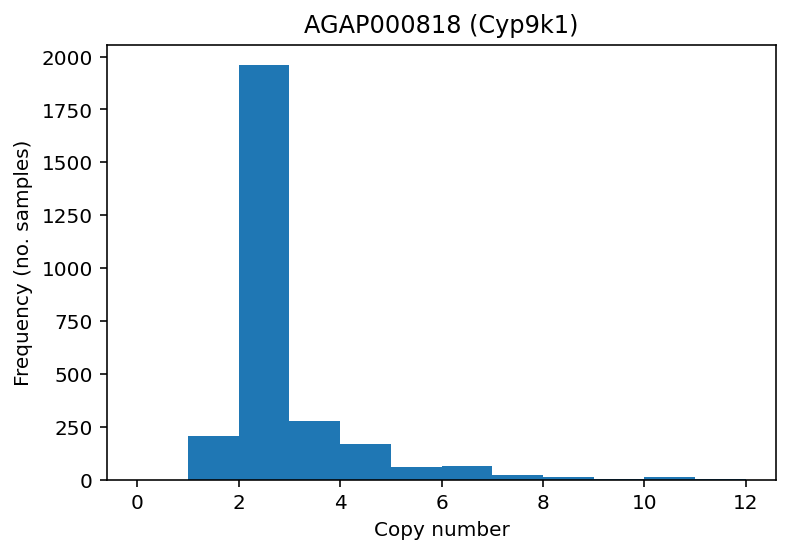

In [30]:
# plot histogram of Cyp9k1 copy number in whole cohort
x = dsg.sel(genes='AGAP000818')['CN_mode'].values
fig, ax = plt.subplots()
ax.hist(x, bins=range(13))
ax.set_xlabel('Copy number')
ax.set_ylabel('Frequency (no. samples)')
ax.set_title('AGAP000818 (Cyp9k1)');

In [31]:
# compute CNV population frequencies by gene 
pops = {
    'bfa_gam': "sample_set == 'AG1000G-BF-A' and species == 'gambiae' and sex_call == 'F'",
    'bfa_col': "sample_set == 'AG1000G-BF-A' and species == 'coluzzii' and sex_call == 'F'",
}
dfgf = ag3.gene_cnv_frequencies(contig='X', populations=pops)
dfgf

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.1s


,seqid,start,end,strand,Name,bfa_gam_amp,bfa_gam_del,bfa_col_amp,bfa_col_del
ID,,,,,,,,,
AGAP000002,X,582,16387,-,KIBRLG,0.013699,0.000000,0.000000,0.000000
AGAP000005,X,32382,38843,-,NaN,0.027397,0.000000,0.025641,0.000000
AGAP000007,X,83817,88773,-,IGL1,0.000000,0.000000,0.000000,0.000000
AGAP000008,X,90142,94903,+,NaN,0.000000,0.000000,0.012821,0.000000
AGAP000009,X,96532,117445,-,NaN,0.000000,0.000000,0.025641,0.000000
...,...,...,...,...,...,...,...,...,...
AGAP013312,X,23863618,23864713,-,NaN,0.000000,0.753425,0.012821,0.076923
AGAP001091,X,23957193,23998340,+,NaN,0.000000,0.000000,0.000000,0.000000
AGAP001092,X,24086190,24087589,+,NaN,0.000000,0.000000,0.038462,0.000000


In [32]:
# extract CNV frequencies for Cyp9k1
dfgf.loc['AGAP000818']

seqid                 X
start          15240572
end            15242864
strand                -
Name             CYP9K1
bfa_gam_amp           1
bfa_gam_del           0
bfa_col_amp    0.025641
bfa_col_del           0
Name: AGAP000818, dtype: object

Thus amplifications are fixed (100%) in gambiae but still at low frequency (2.5%) in coluzzii.

#### *Cyp6aa/p*

In [33]:
plot_hmm_cnv(contig='2R', start=28_450_000, stop=28_550_000, 
             sample_sets='AG1000G-BF-A', sample_query='species == "gambiae" and sex_call == "F"')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.3s


In [34]:
plot_hmm_cnv(contig='2R', start=28_450_000, stop=28_550_000, 
             sample_sets='AG1000G-BF-A', sample_query='species == "coluzzii" and sex_call == "F"')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s


Investigate CNV frequencies by gene within the Cyp6aa/p cluster...

In [35]:
pops = {
    'bfa_gam': "sample_set == 'AG1000G-BF-A' and species == 'gambiae' and sex_call == 'F'",
    'bfa_col': "sample_set == 'AG1000G-BF-A' and species == 'coluzzii' and sex_call == 'F'",
}
dfgf = ag3.gene_cnv_frequencies(contig='2R', populations=pops)
dfgf

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  0.1s


,seqid,start,end,strand,Name,bfa_gam_amp,bfa_gam_del,bfa_col_amp,bfa_col_del
ID,,,,,,,,,
AGAP001096,2R,3426,9985,+,NaN,0.000000,0.041096,0.012821,0.115385
AGAP013094,2R,13754,15149,+,NaN,0.000000,0.000000,0.012821,0.038462
AGAP001097,2R,18496,19579,+,NaN,0.000000,0.000000,0.000000,0.012821
AGAP001098,2R,19797,21866,+,NaN,0.000000,0.000000,0.000000,0.012821
AGAP001099,2R,21882,31394,-,NaN,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
AGAP004671,2R,61176240,61192895,+,NaN,0.000000,0.000000,0.012821,0.000000
AGAP004672,2R,61230781,61254533,+,NaN,0.000000,0.000000,0.012821,0.000000
AGAP004674,2R,61303692,61306248,-,NaN,0.000000,0.000000,0.025641,0.000000


In [36]:
# extract CNV frequencies for Cyp6aa/p cluster
dfgf.query('start > 28_450_000 and end < 28_550_000')

,seqid,start,end,strand,Name,bfa_gam_amp,bfa_gam_del,bfa_col_amp,bfa_col_del
ID,,,,,,,,,
AGAP002862,2R,28480576,28482637,-,CYP6AA1,0.054795,0.000000,0.897436,0.0
AGAP013128,2R,28483301,28484921,-,CYP6AA2,0.054795,0.000000,0.807692,0.0
AGAP002863,2R,28485262,28487080,-,COEAE6O,0.027397,0.000000,0.576923,0.0
AGAP002864,2R,28487640,28489092,-,CYP6P15P,0.013699,0.000000,0.500000,0.0
AGAP002865,2R,28491415,28493141,-,CYP6P3,0.013699,0.109589,0.038462,0.0
AGAP002866,2R,28494017,28495645,-,CYP6P5,0.027397,0.000000,0.038462,0.0
AGAP002867,2R,28497087,28498674,-,CYP6P4,0.013699,0.000000,0.038462,0.0
AGAP002868,2R,28499251,28500900,-,CYP6P1,0.013699,0.000000,0.038462,0.0
AGAP002869,2R,28501033,28502910,-,CYP6P2,0.013699,0.000000,0.038462,0.0


Here coluzzii is at high frequency for amplifications, and *Cyp6aa1* is at much higher frequency for amplifications (89.7%) than *Cyp6p3* (3.8%).

## API docs

In [37]:
help(ag3.cnv_hmm)

Help on method cnv_hmm in module malariagen_data.ag3:

cnv_hmm(contig, sample_sets='v3_wild', inline_array=True, chunks='auto') method of malariagen_data.ag3.Ag3 instance
    Access CNV HMM data.
    
    Parameters
    ----------
    contig : str
        Chromosome arm, e.g., "3R".
    sample_sets : str or list of str
        Can be a sample set identifier (e.g., "AG1000G-AO") or a list of sample set
        identifiers (e.g., ["AG1000G-BF-A", "AG1000G-BF-B"]) or a release identifier (e.g.,
        "v3") or a list of release identifiers.
    inline_array : bool, optional
        Passed through to dask.array.from_array().
    chunks : str, optional
        If 'auto' let dask decide chunk size. If 'native' use native zarr chunks.
        Also can be a target size, e.g., '200 MiB'.
    
    Returns
    -------
    ds : xarray.Dataset



In [38]:
help(ag3.gene_cnv)

Help on method gene_cnv in module malariagen_data.ag3:

gene_cnv(contig, sample_sets='v3_wild') method of malariagen_data.ag3.Ag3 instance
    Compute modal copy number by gene, from HMM data.
    
    Parameters
    ----------
    contig : str
        Chromosome arm, e.g., "3R".
    sample_sets : str or list of str
        Can be a sample set identifier (e.g., "AG1000G-AO") or a list of sample set
        identifiers (e.g., ["AG1000G-BF-A", "AG1000G-BF-B"]) or a release identifier (e.g.,
        "v3") or a list of release identifiers.
    
    Returns
    -------
    ds : xarray.Dataset



In [39]:
help(ag3.gene_cnv_frequencies)

Help on method gene_cnv_frequencies in module malariagen_data.ag3:

gene_cnv_frequencies(contig, populations, sample_sets='v3_wild') method of malariagen_data.ag3.Ag3 instance
    Compute modal copy number by gene, then compute the frequency of
    amplifications and deletions by population, from HMM data.
    
    Parameters
    ----------
    contig : str
        Chromosome arm, e.g., "3R".
    populations : dict
        Dictionary to map population IDs to sample queries, e.g.,
        {"bf_2012_col": "country == 'Burkina Faso' and year == 2012 and species == 'coluzzii'"}
    sample_sets : str or list of str
        Can be a sample set identifier (e.g., "AG1000G-AO") or a list of sample set
        identifiers (e.g., ["AG1000G-BF-A", "AG1000G-BF-B"]) or a release identifier (e.g.,
        "v3") or a list of release identifiers.
    
    Returns
    -------
    df : pandas.DataFrame



In [40]:
help(ag3.cnv_coverage_calls)

Help on method cnv_coverage_calls in module malariagen_data.ag3:

cnv_coverage_calls(contig, sample_set, analysis, inline_array=True, chunks='auto') method of malariagen_data.ag3.Ag3 instance
    Access CNV HMM data.
    
    Parameters
    ----------
    contig : str
        Chromosome arm, e.g., "3R".
    sample_set : str
        Sample set identifier.
    analysis : {'gamb_colu', 'arab', 'crosses'}
        Name of CNV analysis.
    inline_array : bool, optional
        Passed through to dask.array.from_array().
    chunks : str, optional
        If 'auto' let dask decide chunk size. If 'native' use native zarr chunks.
        Also can be a target size, e.g., '200 MiB'.
    
    Returns
    -------
    ds : xarray.Dataset



In [41]:
help(ag3.cnv_discordant_read_calls)

Help on method cnv_discordant_read_calls in module malariagen_data.ag3:

cnv_discordant_read_calls(contig, sample_sets='v3_wild', inline_array=True, chunks='auto') method of malariagen_data.ag3.Ag3 instance
    Access CNV discordant read calls data.
    
    Parameters
    ----------
    contig : str
        Chromosome arm, e.g., "3R".
    sample_sets : str or list of str
        Can be a sample set identifier (e.g., "AG1000G-AO") or a list of sample set
        identifiers (e.g., ["AG1000G-BF-A", "AG1000G-BF-B"]) or a release identifier (e.g.,
        "v3") or a list of release identifiers.
    inline_array : bool, optional
        Passed through to dask.array.from_array().
    chunks : str, optional
        If 'auto' let dask decide chunk size. If 'native' use native zarr chunks.
        Also can be a target size, e.g., '200 MiB'.
    
    Returns
    -------
    ds : xarray.Dataset

